# SED-ML script python examples

## General notebook setup & support function

In [32]:
import roadrunner
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def outputVariables(model, selections=None, complete=False):
    """ Select output variables for simulation."""
    if complete:
        species_ids = model.model.getBoundarySpeciesIds() + model.model.getFloatingSpeciesIds()
        selections = ["time"] + species_ids + [f'[{sid}]' for sid in species_ids] \
            + model.model.getReactionIds() + model.model.getCompartmentIds() + model.model.getGlobalParameterIds()
    
    model.timeCourseSelections = selections
    model.steadyStateSelections = selections

    
def model(path):
    return roadrunner.RoadRunner(path)

def uniform(model, start, end, steps=1, stochastic=False):
    if stochastic:
        model.setIntegrator('gillespie')
        s = model.simulate(start, end)
    else:
        s = model.simulate(start, end, steps=steps)
    return pd.DataFrame(s, columns=s.colnames)


def onestep(model, end, stochastic=False):
    if stochastic:
        rr.setIntegrator('gillespie')
        s = model.simulate(0, end)
    else:
        s = model.simulate(0, end, steps=1)
    df = pd.DataFrame(s, columns=s.colnames)
    return df.tail(1)


class dotdict(dict):
    """dot.notation access to dictionary attributes.
    Special dicts needed.
    """
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

## Comparisons
```
  model1 = model("BIOMD0000000021.xml")
  model2 = model1
  model2.V_mT = 0.28
  model2.V_dT = 4.8
  task1 = model1.uniform(0, 380, 1000)
  task2 = model2.uniform(0, 380, 1000)
  p1 = plot(task1.time, [task1.Mt, task2.Mt])
  p2 = plot(task1.Cn, task1.Mt)
  p2.addPlot(task2.Cn, task2.Mt)

  p1.show()
  p2.show()
```

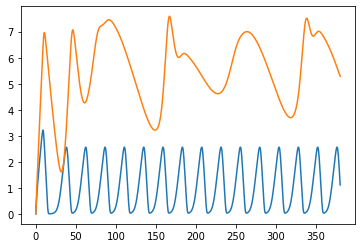

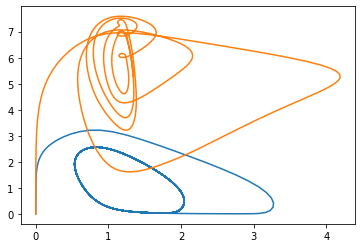

In [18]:
model1 = model("./models/BIOMD0000000021.xml")
# FIXME: necessary to define what is collected!
# any defaults here? (time and species amounts/concentrations? for SBML)
outputVariables(model1, complete=True)

# FIXME: copy of roadrunner objects not possible 
# (see reported issue https://github.com/sys-bio/roadrunner/issues/469)
# We have to reload here
# model2 = model1
model2 = model("./models/BIOMD0000000021.xml")
outputVariables(model2, complete=True)
model2.V_mT = 0.28
model2.V_dT = 4.8


# unclear what 1000 is (steps or points, being explicit here)
task1 = uniform(model1, start=0, end=380, steps=1000)
task2 = uniform(model2, start=0, end=380, steps=1000)

# FIXME: how to access amounts and concentrations?
fig, p1 = plt.subplots()
# p1 is an axes! stacking the vectors to plot at the same time
p1.plot(task1.time, np.stack([task1['[Mt]'], task2['[Mt]']], axis=1))

fig, p2 = plt.subplots()
p2.plot(task1['[Cn]'], task1['[Mt]'])
p2.plot(task2['[Cn]'], task2['[Mt]'])
plt.show()

## Perturbations
```
  model1 = model("oscli.xml")
  task1 = {"time" : range(0, 10.1, 0.1), "S1" : [], "S2", [], "J0_v0", []}
  for x in task1.time:
    if(x>=4 and x < 6):
        model1.J0_v0 = 0.1
    else:
        model1.J0_v0 = 8
    model1.onestep(0.1)
    for element in ['S1', 'S2', 'J0_v0']:
        task1[element].append(model1[element])
  plot(task1.time, [task1.S1, task1.S2, task1.J0_v0])
```

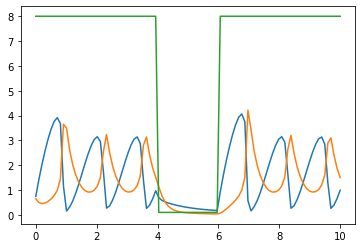

In [19]:
model1 = model("./models/oscli.xml")
outputVariables(model1, ["time", "S1", "S2", "J0_v0"])

# FIXME: basic vectors ! linspace, logspace, zeros_like, ones_like
time = np.linspace(start=0, stop=10, num=100)
task1 = dotdict({
    "time" : time,
    "S1" : np.zeros_like(time), 
    "S2" : np.zeros_like(time), 
    "J0_v0": np.zeros_like(time)
})
# enumerate is very powerful! access to indices
for k, x in enumerate(task1["time"]):
    if (x >= 4 and x < 6):
        model1.J0_v0 = 0.1
    else:
        model1.J0_v0 = 8
    # FIXME: the results have to be returned (are not in the model)
    s = onestep(model1, 0.1)
    # FIXME: unclear amount/concentration
    for element in ['S1', 'S2', 'J0_v0']:
        # doing via index not via append
        task1[element][k] = s[element]

plt.plot(task1.time, np.stack([task1.S1, task1.S2, task1.J0_v0], axis=1))
plt.show()

## Repeated stochastic simulation
```
  model1 = model("borisejb.xml")
  model1.outputVariables(["MAPK", "MAPK_P", "MAPK_PP", "MKK_P", "MKKK", "MKKK_P"])
  p1 = plot()
  for x in range(10):
    mod = model1
    onesim = mod.uniform(0, 4000, stochastic=True, seed = 1003*(x+1))
    p1.addPlot(onesim, x="time")
  p1.show()
```

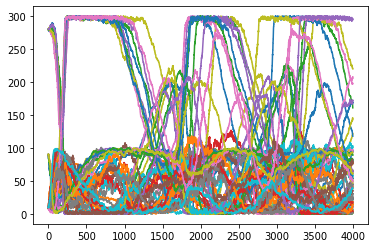

In [20]:
model1 = model("./models/borisejb.xml")
# FIXME: time belongs in the outputVariables
# FIXME: use vector
variableIds = ["MAPK", "MAPK_P", "MAPK_PP", "MKK_P", "MKKK", "MKKK_P"]
outputVariables(model1, ["time"] + variableIds)

fig, p1 = plt.subplots()
for x in range(10):
    # FIXME: we need either a reset here, or a real model copy
    mod = model1
    mod.resetAll()
    
    # FIXME: seed can be set anywhere in simulation script!
    np.random.seed(1003*(x+1))
    onesim = uniform(mod, 0, 4000, stochastic=True)
    p1.plot(onesim.time, onesim[variableIds])

## 1D time course parameter scan
```
  model1 = model("oscli.xml")
  p1 = plot()
  for j0 in [8, 4, 0.4]:
    mod = model1
    mod.J0_v0 = j0
    onesim = mod.uniform(0, 20, 0.01)
    p1.addPot(onesim, x="time")
  p1.show()

```

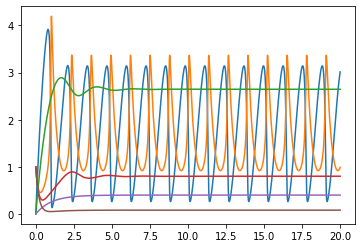

In [25]:
model1 = model("./models/oscli.xml")
# FIXME: output variables must be set (what are defaults otherwise?)
speciesIds = ["S1", "S2"]
outputVariables(model1, ["time"] + speciesIds)

fig, p1 = plt.subplots()
for j0 in [8, 4, 0.4]:
    # FIXME copy or reference needed
    mod = model1
    mod.resetAll()
    
    mod.J0_v0 = j0
    onesim = uniform(mod, 0, 20, steps=2000)
    p1.plot(onesim.time, onesim[speciesIds])

## 2D steady state parameter scan
```
  model_3 = model("borisejb.xml")
  results = dictionary()
  key_species = ["J4_KK5", "MKK", "MKK_P"] 
  for element in key_species:
    results[element] = []
  for kk5 in range(1, 40.4, 0.4):
    for kk2 in [1, 5, 10, 50, 60, 70, 80, 90, 100]:
        mod = model_3
        mod.J4_KK5 = kk5
        mod.J1_KK2 = kk2
        mod.steadystate()
        results.merge(mod)
  plot(results, x="J4_KK5")
```

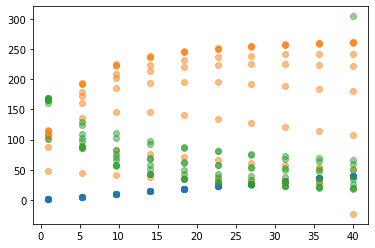

In [28]:
def steadystate(model):
    """Calculate steady state for model."""    
    solver = model.getSteadyStateSolver()
    solver.setSetting("maximum_iterations", 500)
    
    d = dict()
    try:
        model.steadyState()
        
        s = model.getSteadyStateValues()
        for k, key in enumerate(model.steadyStateSelections):
            d[key] = s[k]
    
    except RuntimeError:
        for key in model.steadyStateSelections:
             d[key] = np.nan
    return d


model3 = model("./models/borisejb.xml")
model3.conservedMoietyAnalysis = True
# FIXME: set variables
keys = ["J4_KK5", "[MKK]", "[MKK_P]"]
outputVariables(model3, ["J4_KK5", "[MKK]", "[MKK_P]"])

results = dotdict()
for element in keys:
    results[element] = []

# FIXME: roadrunner, repetitive steadystate always does the L3V2 conversion
    
# FIXME: is the range correct?
# for kk5 in range(1, 40.4, 0.4):
for kk5 in np.linspace(start=1, stop=40, num=10):
    for kk2 in [1, 5, 10, 50, 60, 70, 80, 90, 100]:
        # FIXME model copy
        mod = model3
        mod.resetAll()
        mod.setValue("J4_KK5", kk5)
        mod.setValue("J1_KK2", kk2)
        
        s = steadystate(mod)
        # FIXME: this merge will not work
        # results.merge(mod)
        for key in keys:
            # FIXME: steady state returns only concentrations, probably selections not correct
            # model state not updated
            results[key].append(mod[key])

# convert to DataFrame for plotting
plt.plot(results["J4_KK5"], pd.DataFrame(results), linestyle="None", marker="o", alpha=0.5)
plt.show()

## Herberts list

Run a simulation from time start to time end with a given number of points.
```
model1 = model("model.xml")
sim = model1.uniform(0, 100)
plot(sim, x="time")
```

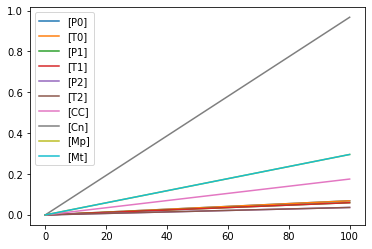

In [39]:
model1 = model("./models/BIOMD0000000021.xml")
# FIXME: some standard way to define subsets of selections
species_ids = [f"[{sid}]" for sid in model1.model.getFloatingSpeciesIds() + model1.model.getBoundarySpeciesIds()]
selections = ["time"] + species_ids
outputVariables(model1, selections=selections)

sim = uniform(model1, start=0, end=100)

fig, p1 = plt.subplots()
for key in species_ids:
    p1.plot(sim.time, sim[key], label=key)
    
# FIXME: how to do legends
p1.legend();

Run a single steady-state simulation, The run returns a 1D array containing the steady-state values.
```
model1 = model("model.xml")
sim = model1.steadystate()
print(sim)
```

In [42]:
model1 = model("./models/BIOMD0000000021.xml")
model1.conservedMoietyAnalysis = True

# FIXME: some standard way to define subsets of selections
species_ids = [f"[{sid}]" for sid in model1.model.getFloatingSpeciesIds() + model1.model.getBoundarySpeciesIds()]
outputVariables(model1, selections=species_ids)

sim = steadystate(model1)
print(sim)


{'[P1]': 0.46922451244623914, '[T1]': 0.46922451244624047, '[P0]': 0.4795553877486213, '[T0]': 0.47955538774862244, '[P2]': 0.40304869313435887, '[T2]': 0.4030486931343611, '[CC]': 0.3052718773855593, '[Mp]': 1.5133296704654717, '[Mt]': 1.5133296704654746, '[Cn]': 0.8722053639587408}


## Working with data

Load experimental data and compare it with simulation data.
```
model1 = model("model.xml")
sim = model1.uniform(0, 100)
exp = dictionary("model_data.csv")
residuals = sum((sim - exp)^2)
residuals.time = sim.time
p1 = plot(sim, x="time")
p1.addPlot(exp, x="time")
p1.addPlot(residuals, x="time")
```

## Create data, manipulate and save

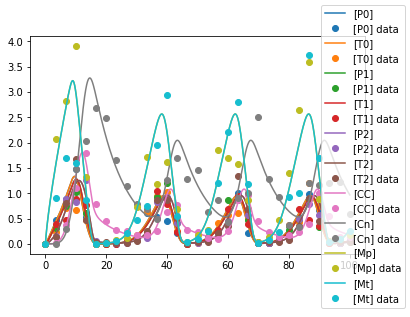

In [93]:
import numpy as np

model1 = model("./models/BIOMD0000000021.xml")
species_ids = [f"[{sid}]" for sid in model1.model.getFloatingSpeciesIds()]
selections = ["time"] + species_ids
outputVariables(model1, selections=selections)

sim = uniform(model1, start=0, end=100, steps=3000)

# creating data
model1.resetAll()
data = uniform(model1, start=0, end=100, steps=30)
Nt = len(data)
for col_id in species_ids:
    data[col_id] = data[col_id] + (np.random.rand(Nt)-0.5)*data[col_id]

data.to_csv("./data/BIOMD0000000021_data.tsv", sep="\t", index=False)
    
fig, p1 = plt.subplots()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for k, key in enumerate(species_ids):
    p1.plot(sim.time, sim[key], label=key, color=colors[k])
    p1.plot(data.time, data[key], linestyle="None", label=f"{key} data", marker="o", color=colors[k])

fig.legend()

## Load data, select subset and plot data

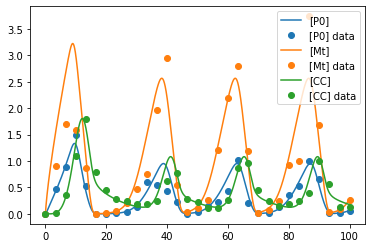

In [94]:
model1 = model("./models/BIOMD0000000021.xml")
data1 = pd.read_csv("./data/BIOMD0000000021_data.tsv", sep="\t")

# FIXME: some standard way to define subsets of selections
species_ids = [f"[{sid}]" for sid in ['P0', 'Mt', 'CC']]
selections = ["time"] + species_ids
outputVariables(model1, selections=selections)

sim1 = uniform(model1, start=0, end=100, steps=3000)

fig, p1 = plt.subplots()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for k, key in enumerate(species_ids):
    color=colors[k]
    p1.plot(sim1.time, sim1[key], label=key, color=color)
    p1.plot(data1.time, data1[key], label=f"{key} data", linestyle="None", marker="o", color=color)
    
p1.legend();

## Load parameters from file
Loading stored parameter combinations and use to run model.

   J4_kk5  J1_kk2
0      10       1
1      20       5
2      30      10
3      40      50
4      10      60
5      20      70
6      30      80
7      40      90


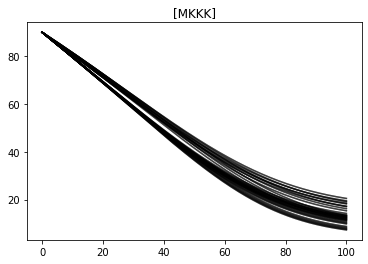

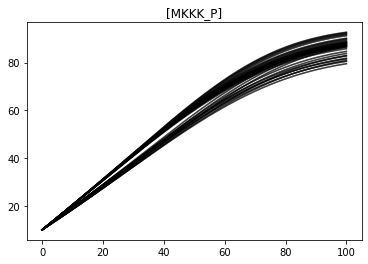

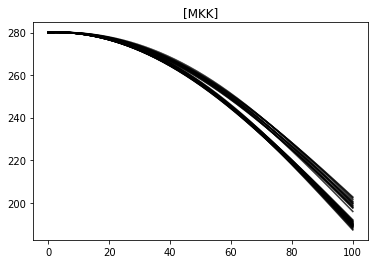

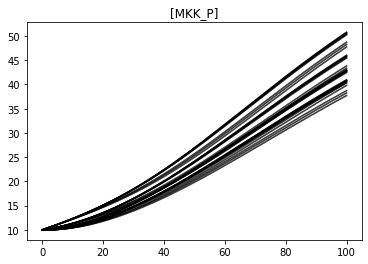

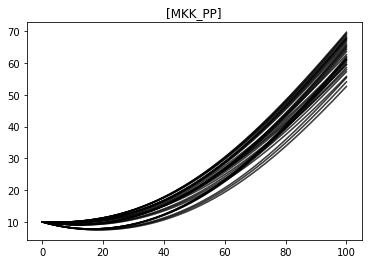

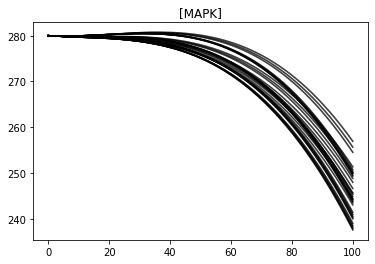

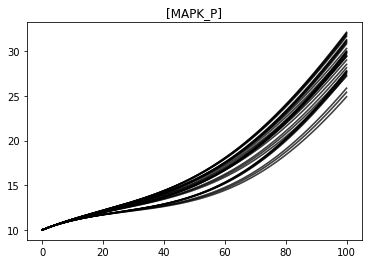

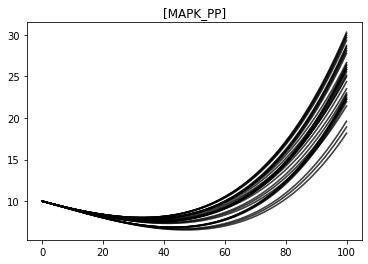

In [116]:
model1 = model("./models/borisejb.xml")
pars1 = pd.read_csv("./data/borisejb_pars.tsv", sep="\t")
print(pars1)

species_ids = [f"[{sid}]" for sid in model1.model.getFloatingSpeciesIds()]
selections = ["time"] + species_ids

results = {}

Nsim = 0
for kk5 in pars1.J4_kk5:
    for kk2 in pars1.J1_kk2:
        Nsim+=1
        model1.resetAll()
        model1.setValue("J4_KK5", kk5)
        model1.setValue("J1_KK2", kk2)
        
        s = uniform(model1, start=0, end=100, steps=1000)
        for key in selections:
            if not key in results:
                results[key] = [ s[key] ]
            else:
                results[key].append(s[key])

for key in species_ids:
    fig, ax = plt.subplots()
    x_data = results['time'] 
    y_data = results[key]
    for k in range(Nsim):
        ax.plot(x_data[k], y_data[k], color="black", alpha=0.5)
        ax.set_title(key)

# FIXME: very complicated to calculate means, sds, min, max over the simulations
# (multi-dimensional tables?)

In [ ]:
Run multiple stochastic simulations, compute means and standard deviations.
model1 = model("model.xml")
results = {}
for x in range(100):
    mod = model1
    onesim = mod.uniform(0, 4000, stochastic=True)
    results.merge(onesim, type="parallel")
means = {}
stdevs = {}
for key in results:
    for list in results[key]:
        means[key] = mean(list)
        stdevs[key] = stdev(list)
stdevs.time = means.time
p1 = plot(means, x="time")
p1.addPlot(stdevs, x="time")
